In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE

In [2]:
# Load data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [3]:
# Basic data exploration
def basic_exploration(data):
    print(data.info())
    print(data.describe())
    print(data.isnull().sum())
    if 'y' in data.columns:
        print(data['y'].value_counts())

basic_exploration(train_data)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  pdays      40000 non-null  int64 
 14  previous   40000 non-null  int64 
 15  poutcome   40000 non-null  object
 16  y          40000 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.2+ MB
None
                age        balance           day      duration      campaign  \
count  40000.0

In [4]:
# Handle missing values (replace 'unknown' with NaN for simplicity)
train_data.replace('unknown', np.nan, inplace=True)
test_data.replace('unknown', np.nan, inplace=True)

In [5]:
# Impute missing values with mode for categorical features
categorical_cols = [col for col in train_data.columns if train_data[col].dtype == 'object' and col != 'y']
for col in categorical_cols:
    train_data[col].fillna(train_data[col].mode()[0], inplace=True)
    test_data[col].fillna(test_data[col].mode()[0], inplace=True)

C:\Users\dhari\AppData\Local\Temp\ipykernel_2220\4135328814.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[col].fillna(train_data[col].mode()[0], inplace=True)
C:\Users\dhari\AppData\Local\Temp\ipykernel_2220\4135328814.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

In [6]:
# Feature engineering for 'pdays'
train_data['previous_contact'] = train_data['pdays'].apply(lambda x: 0 if x == -1 else 1)
test_data['previous_contact'] = test_data['pdays'].apply(lambda x: 0 if x == -1 else 1)

In [7]:
# Drop 'pdays' as it's transformed
train_data.drop('pdays', axis=1, inplace=True)
test_data.drop('pdays', axis=1, inplace=True)


In [15]:
# Splitting features and target
X = train_data.drop(columns=['y'])
y = train_data['y'].map({'yes': 1, 'no': 0})
X_test = test_data

In [17]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [19]:
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

In [21]:
# Preprocessing pipeline
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

In [27]:
# Preprocess the training and validation data
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

In [29]:
# Convert processed data to dense format if necessary
X_train_processed = X_train_processed.toarray() if hasattr(X_train_processed, "toarray") else X_train_processed
X_val_processed = X_val_processed.toarray() if hasattr(X_val_processed, "toarray") else X_val_processed

In [31]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

In [33]:
# Model pipeline
pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42))])

In [35]:
# Hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20, None],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='roc_auc')

In [37]:
# Best model
y_val_pred = grid_search.predict(X_val_processed)
y_val_pred_proba = grid_search.predict_proba(X_val_processed)[:, 1]

In [39]:
# Evaluation
print("Classification Report:")
print(classification_report(y_val, y_val_pred))
print("ROC-AUC Score:", roc_auc_score(y_val, y_val_pred_proba))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      7421
           1       0.49      0.44      0.46       579

    accuracy                           0.93      8000
   macro avg       0.72      0.70      0.71      8000
weighted avg       0.92      0.93      0.92      8000

ROC-AUC Score: 0.93182617410006


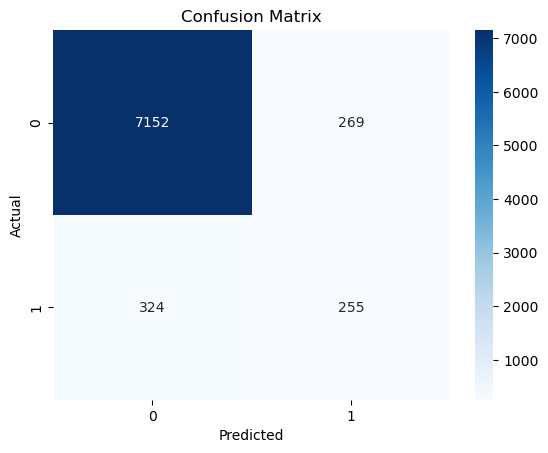

In [41]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [43]:
# Preprocess the test data
X_test_processed = preprocessor.transform(X_test)
X_test_processed = X_test_processed.toarray() if hasattr(X_test_processed, "toarray") else X_test_processed

In [45]:
# Predict on test data
y_test_pred = grid_search.predict(X_test_processed)

In [51]:
# Add predictions to the test dataset
test_data['y'] = y_test_pred
test_data['y'] = test_data['y'].map({1: 'yes', 0: 'no'})

In [53]:
# Save the updated dataset with predictions
test_data.to_csv('Prediction.csv', index=False)
print("Predictions saved to Prediction.csv")

Predictions saved to Prediction.csv
